### Загружаем нужные библиотеки:

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Загружаем данные:

In [0]:
from sklearn.datasets import load_digits
digits = load_digits()

In [5]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [11]:
from google.colab import files
import io
uploaded = files.upload()
X = np.load(io.BytesIO(uploaded['X.npy']))
y = np.load(io.BytesIO(uploaded['Y.npy']))
print(X.shape)
print(y.shape)

Saving X.npy to X (1).npy
Saving Y.npy to Y.npy
(768, 8)
(768,)


### Посмотрим на некоторые изображения:

### Разбиваем данные на обучающую и тестовую выборки

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 7)
N_test, _ = X_test.shape

### Обучаем классификатор

In [0]:
from sklearn.neural_network import MLPClassifier

In [16]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,), solver = 'lbfgs', 
                          activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

### Теперь можем классифицировать:

In [37]:
No = 92
_x = X_test[No, :]
_y = y_test[No]
print(_x,_y)

[  1.    144.     82.     46.    180.     46.1     0.335  46.   ] 1


In [38]:
mlp_model.predict([_x])

array([1])

In [42]:
No = 46
_x = X_test[No, :]
_y = y_test[No]
_y_pred = mlp_model.predict([_x])[0]
print(_x, _y, _y_pred)

[  4.    125.     70.     18.    122.     28.9     1.144  45.   ] 1 0


### Проверяем качество классификатора

In [0]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

Ошибки на обучающей и тестовой выборках:

In [44]:
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.11478599221789883 0.32677165354330706


Можно так:

In [45]:
print(mlp_model.score(X_train, y_train), mlp_model.score(X_test, y_test))

0.8852140077821011 0.6732283464566929


In [46]:
print(1 - mlp_model.score(X_test, y_test))

0.32677165354330706


### Подбор _гипер_параметров

Подберем _оптимальное_ значение параметра регуляризации `alpha`

(Можно вместо циклов, написанных руками, использовать `sklearn.model_selection.GridSearchCV` и т.п.)

In [0]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))

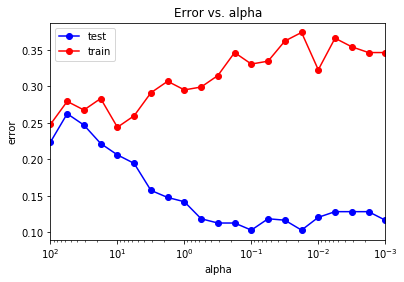

In [48]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'test')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'train')
plt.xlim([np.max(alpha_arr), np.min(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()
pass

Минимальное значение ошибки:

In [49]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.10311284046692606 0.2440944881889764


Оптимальное значение `alpha`:

In [50]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[10.]


In [0]:
alpha_opt = alpha_opt[0]

### Классификатор при найденном _оптимальном_ значении `alpha`:

Повторим обучение:

In [52]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.20622568093385213
0.2440944881889764


### Матрица рассогласования:

In [53]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[143  43]
 [ 19  49]]


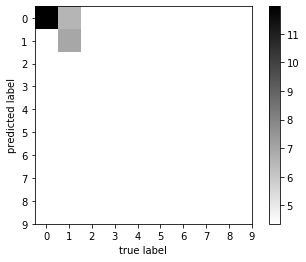

In [54]:
M = confusion_matrix(y_test_pred, y_test)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

### Другие метрики качества:

In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       162
           1       0.72      0.53      0.61        92

    accuracy                           0.76       254
   macro avg       0.74      0.71      0.72       254
weighted avg       0.75      0.76      0.75       254



${\rm error} = \frac{{\rm FP} + {\rm FN}}{{\rm TP} + {\rm TN} + {\rm FP} + {\rm FN}}$ 

${\rm accuracy} = \frac{{\rm TP} + {\rm TN}}{{\rm TP} + {\rm TN} + {\rm FP} + {\rm FN}} = 1 - {\rm error}$ 

${\rm precision} = \frac{{\rm TP}}{{\rm FP}+{\rm TP}}$ 

$F_1 = 2\cdot\frac{{\rm precision}\cdot{\rm recall}}{{\rm precision}+{\rm recall}}$ 





### Все ошибки:

In [58]:
i_subplot = 1 
for i in range(N_test):
    _x = X_test[i, :]
    _y = y_test[i]
    _y_pred = mlp_model.predict([_x])[0]
    if _y_pred != _y:
        print(_x, _y, _y_pred)
        i_subplot += 1

[ 13.    152.     90.     33.     29.     26.8     0.731  43.   ] 1 0
[  6.    125.     78.     31.      0.     27.6     0.565  49.   ] 1 0
[  3.    139.     54.      0.      0.     25.6     0.402  22.   ] 1 0
[ 13.    153.     88.     37.    140.     40.6     1.174  39.   ] 0 1
[  4.    125.     70.     18.    122.     28.9     1.144  45.   ] 1 0
[ 1.    88.    30.    42.    99.    55.     0.496 26.   ] 1 0
[  6.    125.     68.     30.    120.     30.      0.464  32.   ] 0 1
[ 10.    111.     70.     27.      0.     27.5     0.141  40.   ] 1 0
[  5.    130.     82.      0.      0.     39.1     0.956  37.   ] 1 0
[  1.    128.     88.     39.    110.     36.5     1.057  37.   ] 1 0
[  3.    169.     74.     19.    125.     29.9     0.268  31.   ] 1 0
[  0.    146.     70.      0.      0.     37.9     0.334  28.   ] 1 0
[  2.    141.     58.     34.    128.     25.4     0.699  24.   ] 0 1
[  0.    109.     88.     30.      0.     32.5     0.855  38.   ] 1 0
[  8.    125.     96.      0